# Housekeeping

In [1]:
%run 'Setup.py'

8 different classes: Electronic, Experimental, Folk, Hip-Hop, Instrumental, International, Pop or Rock.
objective 1: construct a classifier which, based on the features of a song, predicts its genre
objective 2: estimate its generalisation error under the 0–1 loss.
Features are real-valued, correspond to summary statistics (mean, sd, skewness, kurtosis, median, min, max) of 
time series of various music features, such as the chromagram or the Mel-frequency cepstrum.
Feature description: 

Feature description: 
chroma_cens: Chroma Energy Normalized (CENS, 12 chroma) - 84 features
chroma_cqt: Constant-Q chromagram (12 chroma) - 84 features
chroma_stft: Chromagram (12 chroma) - 84 features
mfcc: Mel-frequency cepstrum (20 coefficients) - 140 features
rmse: Root-mean-square - 7 features
spectral_bandwidth: Spectral bandwidth - 7 features
spectral_centroid: Spectral centroid - 7 features
spectral_contrast: Spectral contrast (7 frequency bands) - 49 features
spectral_rolloff: Roll-off freque

## Import and Prepare Data

In [17]:
# Prepare data
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train_np.ravel())

# Split training data into training and temporary validation sets
X_train, X_temp, Y_train, Y_temp = train_test_split(x_train_np, y_train_encoded, test_size=0.4, random_state=42)

# Split the temporary validation set into validation and test sets
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)  
X_real_test_scaled = scaler.transform(x_test_np)

X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train, dtype=torch.int64)
X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
Y_val_tensor = torch.tensor(Y_val, dtype=torch.int64)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
Y_test_tensor = torch.tensor(Y_test, dtype=torch.int64)
# Repeat for actual (no labels available) test set
X_real_test_tensor = torch.tensor(X_real_test_scaled, dtype=torch.float32)

# Create TensorDatasets and DataLoaders for training, validation, test sets
train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, Y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, Y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

train_loader_128 = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader_128 = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader_128 = DataLoader(test_dataset, batch_size=128, shuffle=False)

# Creating a DataLoader for the test set specifically for prediction purposes
# As there are no test labels, we only pass in the features
real_test_dataset = TensorDataset(X_real_test_tensor)  # Note: This only contains features
real_test_loader = DataLoader(real_test_dataset, batch_size=64, shuffle=False)  # For generating predictions

# Initialize device
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

## Evaluation Functions for sklearn and pytorch models

In [3]:
def evaluate_pytorch_model(model, dataloaders, device):
    model.eval()  # Set the model to evaluation mode
    performance = {}
    with torch.no_grad():  # No need to track gradients
        for phase in ['train', 'val', 'test']:  # Ensure dataloaders includes all phases you wish to evaluate
            if phase not in dataloaders:  # Skip if DataLoader is not provided for the phase
                continue
            correct, total = 0, 0
            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
            accuracy = correct / total
            performance[phase + '_accuracy'] = accuracy
            print(f'Accuracy of the {model.__class__.__name__} model on the {phase} set: {accuracy:.2f}')
    # return performance

def evaluate_sklearn_model(model, X_train, Y_train, X_test, Y_test):
    performance = {}
    for phase, X, Y in [('train', X_train, Y_train), ('test', X_test, Y_test)]:
        predicted = model.predict(X)
        accuracy = np.mean(predicted == Y)
        performance[phase + '_accuracy'] = accuracy
        print(f'Accuracy of the {model.__class__.__name__} model on the {phase} set: {accuracy:.2f}')
    return performance



## Functions to generate Predictions

In [4]:
def map_predictions_to_genres(predictions, label_encoder):
    genre_predictions = label_encoder.inverse_transform(predictions)
    return genre_predictions

def make_predictions_pytorch(model, X_test_tensor, device):
    model.eval()  # Set the model to evaluation mode
    X_test_tensor = X_test_tensor.to(device)
    with torch.no_grad():  # No need to track the gradients
        outputs = model(X_test_tensor)
        _, predictions = torch.max(outputs, 1)
    # Convert predictions to CPU and numpy for easier handling
    predictions = predictions.cpu().numpy()
    return predictions

def make_predictions_sklearn(model, X_test_scaled):
    predictions = model.predict(X_test_scaled)
    return predictions


## Initialize

In [5]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

## Try MLPs

In [6]:
class CustomNN(nn.Module):
    def __init__(self, input_size, num_classes, num_layers=2, hidden_size=100):
        super(CustomNN, self).__init__()
        self.layers = nn.ModuleList()
        
        for i in range(num_layers):
            if i == 0:
                self.layers.append(nn.Linear(input_size, hidden_size))
            else:
                self.layers.append(nn.Linear(hidden_size, hidden_size))
            self.layers.append(nn.ReLU())

        self.output_layer = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        x = self.output_layer(x)
        return x


In [7]:
def train_and_validate(model, train_loader, val_loader, device, optimizer, criterion, epochs=10):
    model.train()  # Set the model to training mode
    for epoch in range(epochs):
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
    
    # Validation phase
    model.eval()  # Set the model to evaluation mode
    total, correct = 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    val_accuracy = correct / total
    return val_accuracy


In [11]:
import optuna
all_models = []
def objective(trial):
    # Hyperparameters to tune
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
    num_layers = trial.suggest_int('num_layers', 1, 3)
    hidden_size = trial.suggest_int('hidden_size', 50, 500)
    
    # Model initialization
    model = CustomNN(input_size=X_train.shape[1], num_classes=len(np.unique(Y_train)),
                     num_layers=num_layers, hidden_size=hidden_size).to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    # Train and validate
    val_accuracy = train_and_validate(model, train_loader, val_loader, device, optimizer, criterion, epochs=10)
    
    # Save the model and trial information
    all_models.append({'trial_id': trial.number, 'model': model, 'val_accuracy': val_accuracy})
    
    return val_accuracy


In [12]:
study = optuna.create_study(direction='maximize', study_name='MLP')
study.optimize(objective, n_trials=50)  # Adjust the number of trials as needed

print("Best trial:")
trial = study.best_trial

print(f"Value: {trial.value}")
print("Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")


[I 2024-03-12 10:21:39,537] A new study created in memory with name: MLP
/var/folders/lq/x2t80c813gsbg58jgjy302hc0000gn/T/ipykernel_20829/1964658944.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
[I 2024-03-12 10:21:43,334] Trial 0 finished with value: 0.13 and parameters: {'lr': 0.04943102532296655, 'num_layers': 2, 'hidden_size': 447}. Best is trial 0 with value: 0.13.
/var/folders/lq/x2t80c813gsbg58jgjy302hc0000gn/T/ipykernel_20829/1964658944.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
[I 2024-03-12 10:21:46,929] Trial 1 finished with value: 0.1175 and paramet

Best trial:
Value: 0.59
Params: 
    lr: 0.0001961798678272242
    num_layers: 2
    hidden_size: 287


In [13]:
# Find the best model based on validation accuracy
best_model_info = max(all_models, key=lambda x: x['val_accuracy'])
best_model = best_model_info['model']

# Test the best model
evaluate_pytorch_model(best_model, dataloaders={'train': train_loader, 'val': val_loader, 'test': test_loader}, device=device)

Accuracy of the CustomNN model on the test set: 0.57
Test accuracy of the best model: 0.57


## Try more complex type of MLP that includes batch norm and dropout layers, weight decay

In [22]:
class AdvancedCustomNN(nn.Module):
    def __init__(self, input_size, num_classes, num_layers=2, hidden_size=100, dropout_rate=0.0, use_batch_norm=False):
        super(AdvancedCustomNN, self).__init__()
        layers = []
        
        for i in range(num_layers):
            if i == 0:
                layers.append(nn.Linear(input_size, hidden_size))
            else:
                layers.append(nn.Linear(hidden_size, hidden_size))
            if use_batch_norm:
                layers.append(nn.BatchNorm1d(hidden_size))
            layers.append(nn.ReLU())
            if dropout_rate > 0:
                layers.append(nn.Dropout(dropout_rate))
                
        layers.append(nn.Linear(hidden_size, num_classes))
        self.layers = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.layers(x)


In [23]:
all_advanced_mlps = []
def advanced_objective(trial):
    lr = trial.suggest_float('lr', 1e-5, 1e-1, log=True)
    num_layers = trial.suggest_int('num_layers', 2, 8)
    hidden_size = trial.suggest_int('hidden_size', 50, 600)
    dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.5)
    use_batch_norm = trial.suggest_categorical('use_batch_norm', [True, False])
    weight_decay = trial.suggest_float('weight_decay', 1e-5, 1e-1, log=True)
    
    model = AdvancedCustomNN(input_size=X_train.shape[1], num_classes=len(np.unique(Y_train)),
                             num_layers=num_layers, hidden_size=hidden_size,
                             dropout_rate=dropout_rate, use_batch_norm=use_batch_norm).to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss()

    val_accuracy = train_and_validate(model, train_loader, val_loader, device, optimizer, criterion, epochs=10)
    # Save the model and trial information
    all_advanced_mlps.append({'trial_id': trial.number, 'model': model, 'val_accuracy': val_accuracy})
    
    return val_accuracy


In [24]:
study = optuna.create_study(direction='maximize', study_name="MLP Advanced")
study.optimize(advanced_objective, n_trials=100)  # Adjust n_trials based on computational resources

print("Best trial:")
trial = study.best_trial
print(f"Value: {trial.value}")
print("Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2024-03-12 10:46:50,490] A new study created in memory with name: MLP Advanced
[I 2024-03-12 10:46:54,739] Trial 0 finished with value: 0.215 and parameters: {'lr': 0.029693039179081178, 'num_layers': 2, 'hidden_size': 298, 'dropout_rate': 0.0549761785428165, 'use_batch_norm': False, 'weight_decay': 0.0001255774217419407}. Best is trial 0 with value: 0.215.
[I 2024-03-12 10:47:01,761] Trial 1 finished with value: 0.5375 and parameters: {'lr': 0.0007653691103371721, 'num_layers': 4, 'hidden_size': 350, 'dropout_rate': 0.42754094470463205, 'use_batch_norm': False, 'weight_decay': 0.007886953688015768}. Best is trial 1 with value: 0.5375.
[I 2024-03-12 10:47:13,870] Trial 2 finished with value: 0.30583333333333335 and parameters: {'lr': 1.761149645792615e-05, 'num_layers': 6, 'hidden_size': 511, 'dropout_rate': 0.28951318340722837, 'use_batch_norm': True, 'weight_decay': 0.00030901218031428266}. Best is trial 1 with value: 0.5375.
[I 2024-03-12 10:47:25,464] Trial 3 finished with value

Best trial:
Value: 0.6108333333333333
Params: 
    lr: 0.002510743937214214
    num_layers: 2
    hidden_size: 203
    dropout_rate: 0.29155280806806994
    use_batch_norm: True
    weight_decay: 1.8025253411305663e-05


In [25]:
# Find the best model based on validation accuracy
best_adv_mlp_info = max(all_advanced_mlps, key=lambda x: x['val_accuracy'])
best_adv_mlp = best_adv_mlp_info['model']

evaluate_pytorch_model(best_adv_mlp, dataloaders={'train': train_loader, 'val': val_loader, 'test': test_loader}, device=device)

Accuracy of the AdvancedCustomNN model on the train set: 0.89
Accuracy of the AdvancedCustomNN model on the val set: 0.61
Accuracy of the AdvancedCustomNN model on the test set: 0.59


## Manually experiment with MLP Architectures

In [12]:
import time
import matplotlib.pyplot as plt
import torch.nn.functional as F
def train_and_validate_with_plot(model, train_loader, val_loader, device, optimizer, criterion, epochs=10):
    # Lists to keep track of losses and timing
    train_losses = []
    val_losses = []
    start_time = time.time()
    
    for epoch in range(epochs):
        model.train()  # Set the model to training mode
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        # Calculate and store the average training loss
        train_losses.append(running_loss / len(train_loader))
        running_loss = 0.0  # Reset running loss for validation
        
        # Validation phase
        model.eval()  # Set the model to evaluation mode
        total, correct = 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)  # Corrected to use labels
                running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
            # Calculate and store the average validation loss
            val_losses.append(running_loss / len(val_loader))

    end_time = time.time()
    elapsed_time = (end_time - start_time) / 60  # Time in minutes
    
    # Plotting the training and validation loss
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    val_accuracy = correct / total
    print(f"Training completed in: {elapsed_time:.2f} minutes")
    return val_accuracy


In [13]:
class ManualNN(nn.Module):
    def __init__(self, input_size=518, num_classes=8, dropout_rate=0.3, hidden_units=[256, 128, 64, 32]):
        super(ManualNN, self).__init__()

        # Define the layers
        self.dropout = nn.Dropout(p=dropout_rate)
        self.bn_layers = nn.ModuleList([nn.BatchNorm1d(hidden_units[i]) for i in range(len(hidden_units))])

        self.input_layer = nn.Linear(input_size, hidden_units[0])
        self.hidden_layers = nn.ModuleList([nn.Linear(hidden_units[i], hidden_units[i+1]) for i in range(len(hidden_units)-1)])
        self.output_layer = nn.Linear(hidden_units[-1], num_classes)

    def forward(self, x):
        # Forward pass through each layer
        x = self.bn_layers[0](self.input_layer(x))
        x = F.relu(x)
        for i, layer in enumerate(self.hidden_layers):
            x = self.bn_layers[i+1](layer(x))
            x = F.relu(x)
            x = self.dropout(x)
        x = self.output_layer(x)
        return x

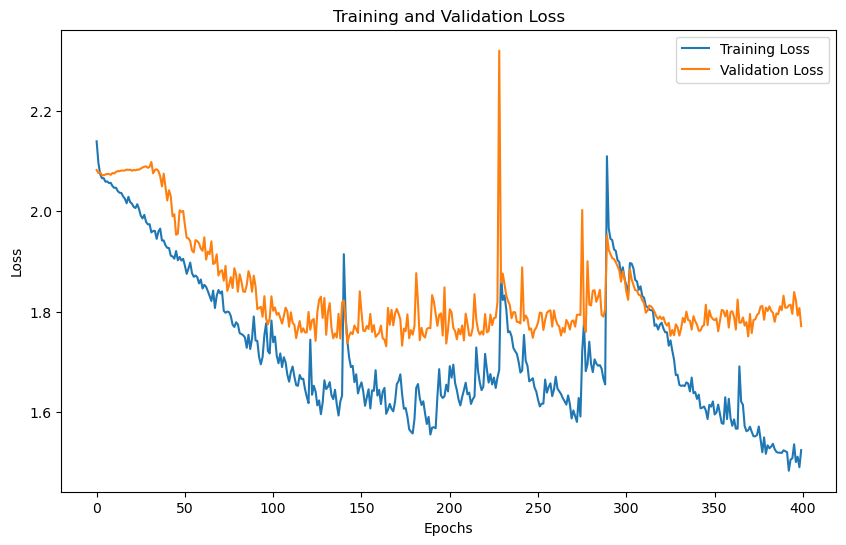

Training completed in: 16.84 minutes
Accuracy of the ManualNN model on the train set: 0.45
Accuracy of the ManualNN model on the val set: 0.31
Accuracy of the ManualNN model on the test set: 0.31


In [14]:
# Instantiate
NN = ManualNN(hidden_units=[2056] * 4 + [1028] * 4 + [512]*4 + [256]*4 + [128]*4 + [64]*4 + [32,16], dropout_rate=0.4).to(device)
# Define optimizer and loss function
# optimizer = torch.optim.Adam(NN.parameters(), lr=0.001)
optimizer = torch.optim.SGD(NN.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()

# Train and validate the model
epochs = 400
val_accuracy = train_and_validate_with_plot(NN, train_loader, val_loader, device, optimizer, criterion, epochs)
evaluate_pytorch_model(NN, dataloaders={'train': train_loader, 'val': val_loader, 'test': test_loader}, device=device)

In [18]:
def train_and_validate_with_plot_es(model, train_loader, val_loader, device, optimizer, criterion, epochs=10, patience=5):
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        train_losses.append(running_loss / len(train_loader))

        model.eval()
        running_loss = 0.0
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
        average_val_loss = running_loss / len(val_loader)
        val_losses.append(average_val_loss)

        # Early Stopping
        if average_val_loss < best_val_loss:
            best_val_loss = average_val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
        if epochs_no_improve == patience:
            print('Early stopping!')
            break

    # Plot losses
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    return model, train_losses, val_losses


Early stopping!


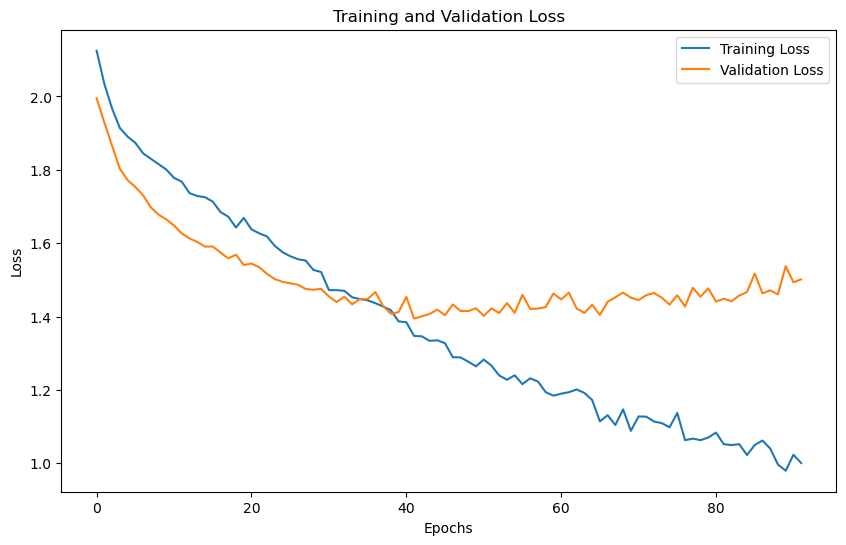

Accuracy of the ManualNN model on the train set: 0.88
Accuracy of the ManualNN model on the val set: 0.52
Accuracy of the ManualNN model on the test set: 0.54


In [43]:
# Try varying batch sizes:
bs = 64
train_loader_vbs = DataLoader(train_dataset, batch_size=bs, shuffle=True)
val_loader_vbs = DataLoader(val_dataset, batch_size=bs, shuffle=False)
test_loader_vbs = DataLoader(test_dataset, batch_size=bs, shuffle=False)
# Instantiate #10360 works fairly well
NN = ManualNN(hidden_units=[268324] + [33540]*0 + [256]*0 + [128] + [64]*1 + [32]* 1 + [16], dropout_rate=0.5).to(device)
# Define optimizer and loss function
# optimizer = torch.optim.Adam(NN.parameters(), lr=0.001)
optimizer = torch.optim.SGD(NN.parameters(), lr=0.01, momentum=0.9)
criterion = nn.MSE()

# Train and evaluate the model
epochs = 500
patience = 50
val_acc = train_and_validate_with_plot_es(NN, train_loader_vbs, val_loader_vbs, device, optimizer, criterion, epochs, patience)
evaluate_pytorch_model(NN, dataloaders={'train': train_loader, 'val': val_loader, 'test': test_loader}, device=device)

In [35]:
print([518]  + [10360] + [5,180]*0 + [512] + [128] + [64]*1 + [16])

[518, 10360, 512, 128, 64, 16]


In [41]:
print([518*1000] + [5,180]*0 + [256]*0 + [128]*0 + [64]*0 + [32]*1 + [16]*0)

[518000, 32]


In [44]:
X_train_scaled.shape

(3600, 518)